# **Подготовка данных**

In [2]:
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
import pandas as pd

X_train = pd.read_csv("/kaggle/input/toxic-wiki-prac2/toxic_train.csv", index_col=0)
X_test = pd.read_csv("/kaggle/input/toxic-wiki-prac2/toxic_test.csv", index_col=0)

In [5]:
X_train.head(5)

comment_text  is_toxic
0  Explanation\nWhy the edits made under my usern...     False
1  D'aww! He matches this background colour I'm s...     False
2  Hey man, I'm really not trying to edit war. It...     False
3  "\nMore\nI can't make any real suggestions on ...     False
4  You, sir, are my hero. Any chance you remember...     False

# **1. Предварительная обработка данных**

Проведем предварительную обработку текстов, заменив все символы, не являющиеся цифрами и буквами, на пробелы. Все символы приведем к нижнему регистру.

In [6]:
import re

def preprocessing_text(text: str):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())

In [7]:
X_train['comment_text'] = X_train['comment_text'].map(preprocessing_text)
X_test['comment_text'] = X_test['comment_text'].map(preprocessing_text)

In [8]:
X_train.head(5)

comment_text  is_toxic
0  explanation why the edits made under my userna...     False
1  d aww  he matches this background colour i m s...     False
2  hey man  i m really not trying to edit war  it...     False
3    more i can t make any real suggestions on im...     False
4  you  sir  are my hero  any chance you remember...     False

# **2. Преобразование данных в матрицу частотности**

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=10)

X_train_v = vectorizer.fit_transform(X_train['comment_text'])
X_text_v = vectorizer.transform(X_test['comment_text'])

print(X_train_v.shape)

(52061, 11237)


# **3. Реализация методов GD и SGD и их сравнение с численным методом подсчета**

In [10]:
import sys
sys.path.append('/kaggle/input/logreg-toxic-task2')

from optimization import GDClassifier, SGDClassifier
from oracles import BinaryLogistic
from utils import grad_finite_diff

Перед подсчетом градиента преобразуем столбцы данных метки токсичности в значения +1, -1 (соответственно, True и False)

In [11]:
y_train = X_train['is_toxic'].map({True: 1, False: -1})
y_test = X_test['is_toxic'].map({True: 1, False: -1})

In [9]:
from scipy.sparse import csr_matrix


X_compare = np.array([[1, 0, 0, 1], [0, 2, 3, 2], [4, 0, 5, 0]])
y_compare = np.array([1, -1, 1])
w_compare = np.array([1, 2, 3, 4])

X_compare = csr_matrix(X_compare)

oracle = BinaryLogistic(2)

print(oracle.grad(X_compare, y_compare, w_compare))
print(grad_finite_diff(lambda x: oracle.func(X_compare, y_compare, x), w_compare))

[1.99776904 4.66666667 6.99999999 8.66443572]
[1.99776977 4.66666705 6.99999987 8.66443628]


# **4. Эксперимент №1: Исследование поведения метода GD в зависимости от начальных данных и гиперпараметров**

In [12]:
# функция измерения точности
from tqdm import tqdm

def accuracy(y_pred, y_test):
    return np.sum(y_pred == y_test)/len(y_test)

default_args = {"loss_function": 'binary_logistic', "step_alpha": 1, "step_beta": 0, "tolerance": 1e-5, "max_iter": 50, "l2_coef": 0.00001}

## **4.1 Исследование поведения от step_alpha**

In [100]:
step_alpha_arr = np.logspace(-5, 0, num=6, base=10)

alpha_history = {}
default_args = {"loss_function": 'binary_logistic', "step_alpha": 1, "step_beta": 0, "tolerance": 1e-5, "max_iter": 50, "l2_coef": 0.00001}

for step_alpha in tqdm(step_alpha_arr):
    args = default_args
    args['step_alpha'] = step_alpha
    
    model = GDClassifier(**args)
    alpha_history[step_alpha] = model.fit(X_train_v, y_train, trace=True)

100%|██████████| 6/6 [00:18<00:00,  3.14s/it]


In [101]:
acc_alpha = {step_alpha: 
             {num_iter: acc for num_iter, acc in enumerate(alpha_history[step_alpha]['accuracy'])}
             for step_alpha in alpha_history.keys()}
acc_alpha = pd.DataFrame(acc_alpha)

loss_alpha = {step_alpha: 
             {num_iter: acc for num_iter, acc in enumerate(alpha_history[step_alpha]['func'])}
             for step_alpha in alpha_history.keys()}
loss_alpha = pd.DataFrame(loss_alpha)

acc_time_alpha = {step_alpha: 
             {time_work: acc for time_work, acc
              in zip(alpha_history[step_alpha]['time'],alpha_history[step_alpha]['accuracy'])}
             for step_alpha in alpha_history.keys()}
acc_time_alpha = pd.DataFrame(acc_time_alpha)

loss_time_alpha = {step_alpha: 
             {time_work: func for time_work, func
              in zip(alpha_history[step_alpha]['time'],alpha_history[step_alpha]['func'])}
             for step_alpha in alpha_history.keys()}
loss_time_alpha = pd.DataFrame(loss_time_alpha)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

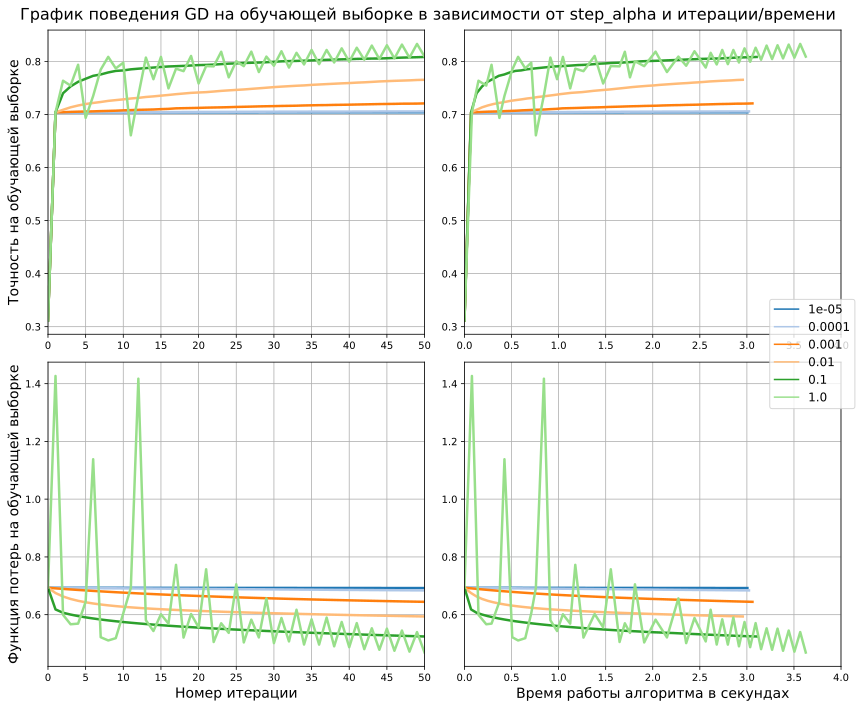

In [104]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

xlim_time = (0, 4)
xlim_iter = (0, 50)
xticks_iter = range(0, 51, 5)

fig.suptitle("График поведения GD на обучающей выборке в зависимости от step_alpha и итерации/времени", fontsize=16)

sns.set_palette("tab20")
ax = axes[0, 0]
plot1 = sns.lineplot(data=acc_alpha, dashes=False, linewidth=2.5, legend=False, ax=ax)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax = axes[0, 1]
plot2 = sns.lineplot(data=acc_time_alpha, dashes=False, linewidth=2.5, legend=False, ax=ax)
ax.set_xlim(xlim_time)
ax.grid()

ax = axes[1, 0]
plot3 = sns.lineplot(data=loss_alpha, dashes=False, linewidth=2.5, legend=False, ax=ax)

ax.set_xlabel("Номер итерации", fontsize=14)
ax.set_ylabel("Функция потерь на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax= axes[1, 1]
plot4 = sns.lineplot(data=loss_time_alpha, dashes=False, linewidth=2.5, legend=True, ax=ax)
ax.set_xlabel("Время работы алгоритма в секундах", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(handles=handles, labels=labels, loc="center right", fontsize=12)

plt.savefig(fname='task2_exp4_alpha.pdf')

plt.tight_layout()
plt.show()

## **4.2 Исследование поведения GD от step_beta**

In [105]:
step_beta_arr = np.logspace(-4, 0, num=5, base=10)

beta_history = {}

default_args = {"loss_function": 'binary_logistic', "step_alpha": 1, "step_beta": 0, "tolerance": 1e-5, "max_iter": 50, "l2_coef": 0.00001}

for step_beta in tqdm(step_beta_arr):
    args = default_args
    args['step_beta'] = step_beta
    
    model = GDClassifier(**args)
    beta_history[step_beta] = model.fit(X_train_v, y_train, trace=True)

100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


In [106]:
acc_beta = {step_beta: 
             {num_iter: acc for num_iter, acc in enumerate(beta_history[step_beta]['accuracy'])}
             for step_beta in beta_history.keys()}
acc_beta = pd.DataFrame(acc_beta)

loss_beta = {step_beta: 
             {num_iter: acc for num_iter, acc in enumerate(beta_history[step_beta]['func'])}
             for step_beta in beta_history.keys()}
loss_beta = pd.DataFrame(loss_beta)

acc_time_beta = {step_beta: 
             {time_work: acc for time_work, acc in zip(beta_history[step_beta]['time'], beta_history[step_beta]['accuracy'])}
             for step_beta in beta_history.keys()}
acc_time_beta = pd.DataFrame(acc_time_beta)

loss_time_beta = {step_beta: 
             {time_work: func for time_work, func in zip(beta_history[step_beta]['time'], beta_history[step_beta]['func'])}
             for step_beta in beta_history.keys()}
loss_time_beta = pd.DataFrame(loss_time_beta)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

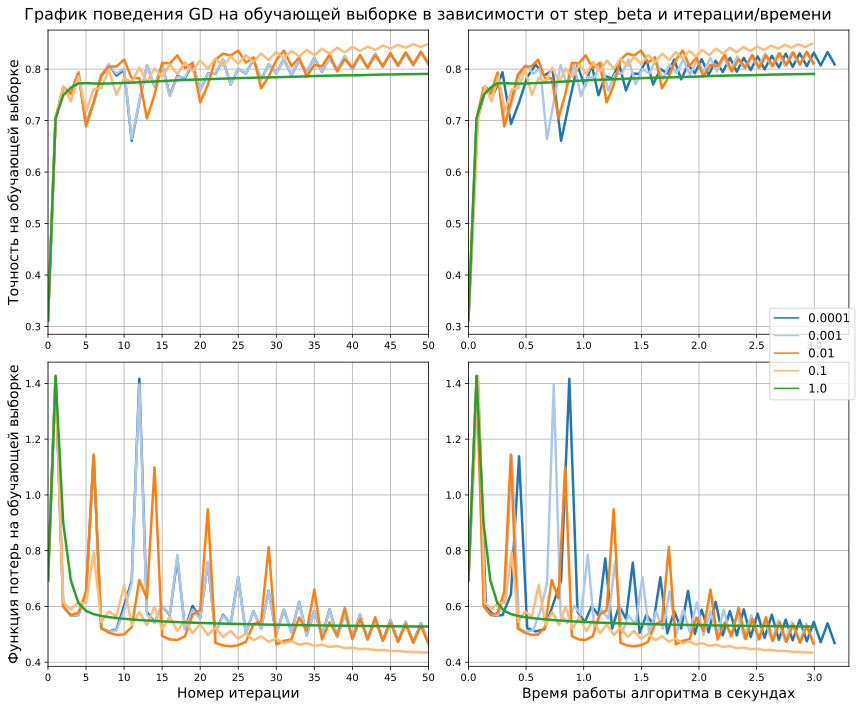

In [110]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

xlim_time = (0, 3.3)
xlim_iter = (0, 50)
xticks_iter = range(0, 51, 5)

fig.suptitle("График поведения GD на обучающей выборке в зависимости от step_beta и итерации/времени", fontsize=16)

ax = axes[0, 0]
plot1 = sns.lineplot(data=acc_beta, dashes=False, linewidth=2.5, legend=False, ax=ax)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax = axes[0, 1]
plot2 = sns.lineplot(data=acc_time_beta, dashes=False, linewidth=2.5, legend=False, ax=ax)
ax.set_xlim(xlim_time)
ax.grid()

ax = axes[1, 0]
plot3 = sns.lineplot(data=loss_beta, dashes=False, linewidth=2.5, legend=False, ax=ax)

ax.set_xlabel("Номер итерации", fontsize=14)
ax.set_ylabel("Функция потерь на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax= axes[1, 1]
plot4 = sns.lineplot(data=loss_time_beta, dashes=False, linewidth=2.5, legend=True, ax=ax)
ax.set_xlabel("Время работы алгоритма в секундах", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(handles=handles, labels=labels, loc="center right", fontsize=12)

plt.savefig(fname='task2_exp4_beta.pdf')

plt.tight_layout()
plt.show()

## **4.3 Исследования поведения от начального приближения**

In [111]:
w_history={}

default_args = {"loss_function": 'binary_logistic', "step_alpha": 1, "step_beta": 0, "tolerance": 1e-5, "max_iter": 50, "l2_coef": 0.00001}

for i in tqdm(range(1, 3), "normal"):
    w_norm = np.random.normal(scale=i, size=X_train_v.shape[1])
    
    model = GDClassifier(**default_args)
    w_history[("norm" + str(i))] = model.fit(X_train_v, y_train, w_norm, trace=True)

for i in tqdm(range(1, 4), "uniform"):
    w_uni = np.random.uniform(low=-i, high=i, size=X_train_v.shape[1])
    model = GDClassifier(**default_args)
    w_history[("unif" + str(i))] = model.fit(X_train_v, y_train, w_uni, trace=True)
    
w_null = np.zeros(X_train_v.shape[1])
model = GDClassifier(**default_args)
w_history["null"] = model.fit(X_train_v, y_train, w_null, trace=True)
print("null")
def w_min_t(X, y, min_num, random_seed=153, **kwargs):
    np.random.seed(random_seed)
    kwargs["max_iter"] = 10
    model = GDClassifier(**kwargs)
    indices = np.random.choice(X.shape[0], size=min_num, replace=False)
    model.fit(X[indices], y.iloc[indices])
    return model.get_weights()
    
for num in tqdm([1000, 2000, 4000, 6000], "batch"):
    w_min = w_min_t(X_train_v, y_train, num, 153, **default_args)

    model = GDClassifier(**default_args)
    w_history["batch" + str(num)] = model.fit(X_train_v, y_train, w_min, trace=True)

w_spec = np.zeros(X_train_v.shape[1])

for i in tqdm(range(X_train_v.shape[1])):
    num = X_train_v[:, i].T @ y_train 
    den = np.sum(X_train_v[:, i].dot(X_train_v[:, i].T))
    w_spec[i] = num / den
    
model = GDClassifier(**default_args)
w_history["spec"] = model.fit(X_train_v, y_train, w_spec, trace=True)
print("spec")

uniform: 100%|██████████| 3/3 [00:09<00:00,  3.01s/it]


null


  0%|          | 0/11237 [00:00<?, ?it/s]/tmp/ipykernel_30/3140344874.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w_spec[i] = num / den
100%|██████████| 11237/11237 [09:51<00:00, 19.01it/s] 


spec


In [112]:
acc_w = {w_name: 
             {num_iter: acc for num_iter, acc in enumerate(w_history[w_name]['accuracy'])}
             for w_name in w_history.keys()}
acc_w = pd.DataFrame(acc_w)

loss_w = {w_name: 
             {num_iter: func for num_iter, func in enumerate(w_history[w_name]['func'])}
             for w_name in w_history.keys()}
loss_w = pd.DataFrame(loss_w)

acc_time_w = {w_name: 
             {time_work: acc for time_work, acc in zip(w_history[w_name]['time'], w_history[w_name]['accuracy'])}
             for w_name in w_history.keys()}
acc_time_w = pd.DataFrame(acc_time_w)

loss_time_w = {w_name: 
             {time_work: func for time_work, func in zip(w_history[w_name]['time'], w_history[w_name]['func'])}
             for w_name in w_history.keys()}
loss_time_w = pd.DataFrame(loss_time_w)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

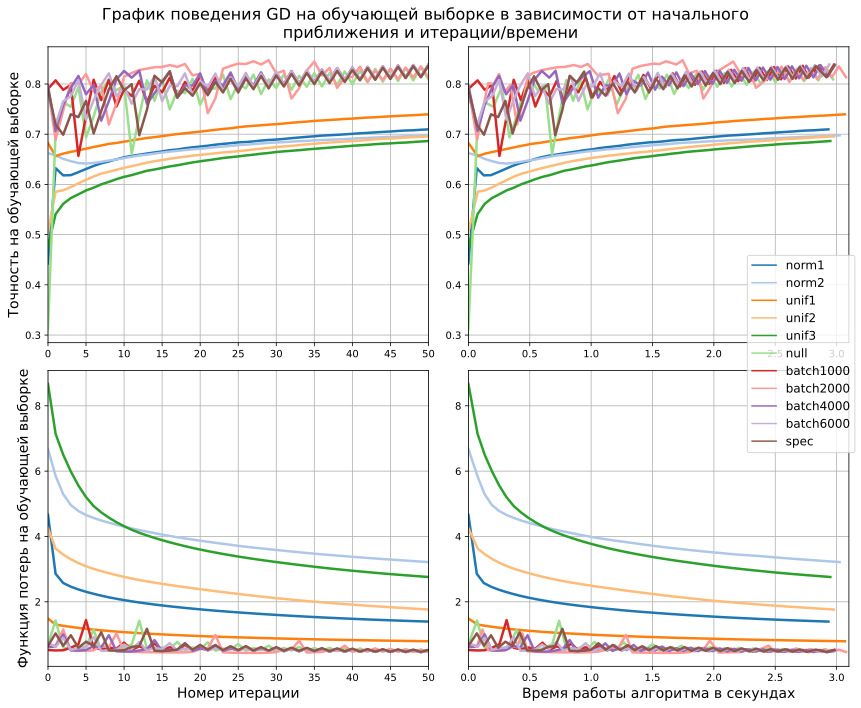

In [115]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

xlim_time = (0, 3.1)
xlim_iter = (0, 50)
xticks_iter = range(0, 51, 5)

fig.suptitle("График поведения GD на обучающей выборке в зависимости от начального \n приближения и итерации/времени", fontsize=16)

sns.set_palette("tab20")
ax = axes[0, 0]
plot1 = sns.lineplot(data=acc_w, dashes=False, linewidth=2.5, legend=False, ax=ax)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax = axes[0, 1]
plot2 = sns.lineplot(data=acc_time_w, dashes=False, linewidth=2.5, legend=False, ax=ax)
ax.set_xlim(xlim_time)
ax.grid()

ax = axes[1, 0]
plot3 = sns.lineplot(data=loss_w, dashes=False, linewidth=2.5, legend=False, ax=ax)

ax.set_xlabel("Номер итерации", fontsize=14)
ax.set_ylabel("Функция потерь на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax= axes[1, 1]
plot4 = sns.lineplot(data=loss_time_w, dashes=False, linewidth=2.5, legend=True, ax=ax)
ax.set_xlabel("Время работы алгоритма в секундах", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(handles=handles, labels=labels, loc="center right", fontsize=12)

plt.savefig(fname='task2_exp4_w.pdf')

plt.tight_layout()
plt.show()

# **5. Эксперимент №2: Исследование поведения метода SGD в зависимости от начальных данных и гиперпараметров**

In [116]:
default_sgd_args = {"loss_function": 'binary_logistic', "step_alpha": 1, "step_beta": 0,
                    "tolerance": 1e-5, "max_iter": 50, "random_seed": 153, "l2_coef": 0.00001, "batch_size": 1000}

## **5.1 Исследование поведения SGD от step_alpha**

In [120]:
step_alpha_arr = np.logspace(-5, 0, num=6, base=10)

alpha_history = {}

for step_alpha in tqdm(step_alpha_arr):
    args = default_sgd_args
    args['step_alpha'] = step_alpha
    
    model = SGDClassifier(**args)
    alpha_history[step_alpha] = model.fit(X_train_v, y_train, trace=True, log_freq=0.3)

100%|██████████| 6/6 [01:27<00:00, 14.54s/it]


In [121]:
acc_alpha = {step_alpha: 
             {num_iter: acc for num_iter, acc in zip(alpha_history[step_alpha]['epoch_num'], alpha_history[step_alpha]['accuracy'])}
             for step_alpha in alpha_history.keys()}
acc_alpha = pd.DataFrame(acc_alpha)

loss_alpha = {step_alpha: 
             {num_iter: func for num_iter, func in zip(alpha_history[step_alpha]['epoch_num'], alpha_history[step_alpha]['func'])}
             for step_alpha in alpha_history.keys()}
loss_alpha = pd.DataFrame(loss_alpha)

acc_time_alpha = {step_alpha: 
             {time_work: acc for time_work, acc in zip(alpha_history[step_alpha]['time'], alpha_history[step_alpha]['accuracy'])}
             for step_alpha in alpha_history.keys()}
acc_time_alpha = pd.DataFrame(acc_time_alpha)

loss_time_alpha = {step_alpha: 
             {time_work: func for time_work, func in zip(alpha_history[step_alpha]['time'], alpha_history[step_alpha]['func'])}
             for step_alpha in alpha_history.keys()}
loss_time_alpha = pd.DataFrame(loss_time_alpha)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

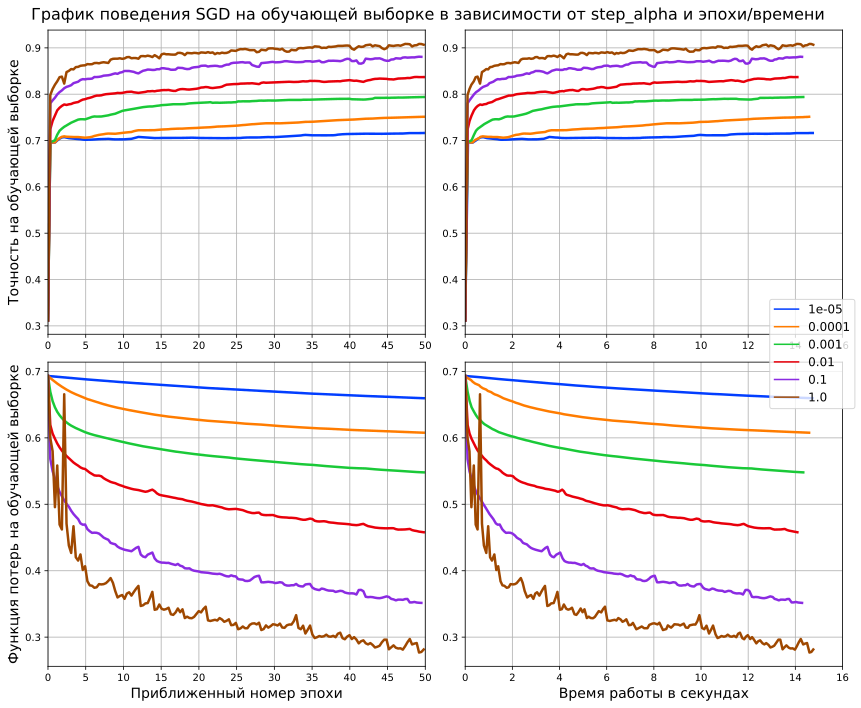

In [123]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

xlim_time = (0, 16)
xlim_iter = (0, 50)
xticks_iter = range(0, 51, 5)

fig.suptitle("График поведения SGD на обучающей выборке в зависимости от step_alpha и эпохи/времени", fontsize=16)

sns.set_palette("tab20")
ax = axes[0, 0]
plot1 = sns.lineplot(data=acc_alpha, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax = axes[0, 1]
plot2 = sns.lineplot(data=acc_time_alpha, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_xlim(xlim_time)
ax.grid()

ax = axes[1, 0]
plot3 = sns.lineplot(data=loss_alpha, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)

ax.set_xlabel("Приближенный номер эпохи", fontsize=14)
ax.set_ylabel("Функция потерь на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax= axes[1, 1]
plot4 = sns.lineplot(data=loss_time_alpha, dashes=False, palette="bright", linewidth=2.5, legend=True, ax=ax)
ax.set_xlabel("Время работы в секундах", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(handles=handles, labels=labels, loc="center right", fontsize=12)

plt.savefig(fname='task2_exp5_alpha.pdf')

plt.tight_layout()
plt.show()

## **5.2 Исследование поведения SGD от step_beta**

In [124]:
step_beta_arr = np.logspace(-4, 0, num=5, base=10)

beta_history = {}
default_sgd_args = {"loss_function": 'binary_logistic', "step_alpha": 1, "step_beta": 0,
                    "tolerance": 1e-5, "max_iter": 50, "random_seed": 153, "l2_coef": 0.00001, "batch_size": 1000}

for step_beta in tqdm(step_beta_arr):
    args = default_sgd_args
    args['step_beta'] = step_beta
    
    model = SGDClassifier(**args)
    beta_history[step_beta] = model.fit(X_train_v, y_train, trace=True, log_freq=0.3)

100%|██████████| 5/5 [01:12<00:00, 14.58s/it]


In [126]:
acc_beta = {step_beta: 
             {num_iter: acc for num_iter, acc in zip(beta_history[step_beta]['epoch_num'], beta_history[step_beta]['accuracy'])}
             for step_beta in beta_history.keys()}
acc_beta = pd.DataFrame(acc_beta)

loss_beta = {step_beta: 
             {num_iter: func for num_iter, func in zip(beta_history[step_beta]['epoch_num'], beta_history[step_beta]['func'])}
             for step_beta in beta_history.keys()}
loss_beta = pd.DataFrame(loss_beta)

acc_time_beta = {step_beta: 
             {time_work: acc for time_work, acc in zip(beta_history[step_beta]['time'], beta_history[step_beta]['accuracy'])}
             for step_beta in beta_history.keys()}
acc_time_beta = pd.DataFrame(acc_time_beta)

loss_time_beta = {step_beta:
             {time_work: func for time_work, func in zip(beta_history[step_beta]['time'], beta_history[step_beta]['func'])}
             for step_beta in beta_history.keys()}
loss_time_beta = pd.DataFrame(loss_time_beta)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

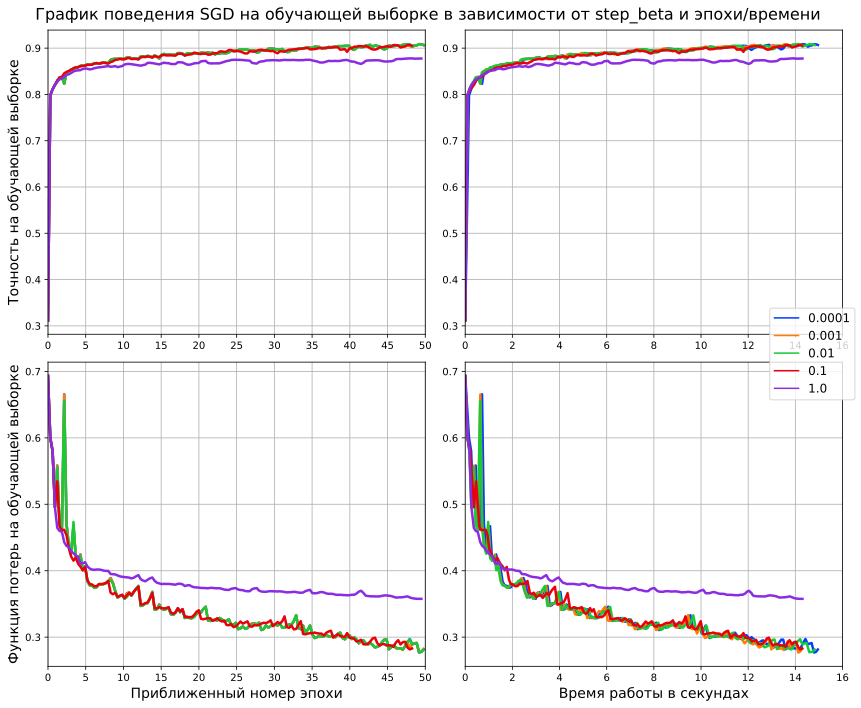

In [130]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

xlim_time = (0, 16)
xlim_iter = (0, 50)
xticks_iter = range(0, 51, 5)

fig.suptitle("График поведения SGD на обучающей выборке в зависимости от step_beta и эпохи/времени", fontsize=16)
sns.set_palette("tab20")

ax = axes[0, 0]
plot1 = sns.lineplot(data=acc_beta, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax = axes[0, 1]
plot2 = sns.lineplot(data=acc_time_beta, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_xlim(xlim_time)
ax.grid()

ax = axes[1, 0]
plot3 = sns.lineplot(data=loss_beta, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)

ax.set_xlabel("Приближенный номер эпохи", fontsize=14)
ax.set_ylabel("Функция потерь на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax= axes[1, 1]
plot4 = sns.lineplot(data=loss_time_beta, dashes=False, palette="bright", linewidth=2.5, legend=True, ax=ax)
ax.set_xlabel("Время работы в секундах", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(handles=handles, labels=labels, loc="center right", fontsize=12)

plt.savefig(fname='task2_exp5_beta.pdf')

plt.tight_layout()
plt.show()

## **5.3 Исследования поведения SGD от batch_size**

In [131]:
batch_size_arr = [10, 30, 100, 300, 1000, 3000, 10000, 30000]

batch_history = {}
default_sgd_args = {"loss_function": 'binary_logistic', "step_alpha": 1, "step_beta": 0,
                    "tolerance": 1e-5, "max_iter": 50, "random_seed": 153, "l2_coef": 0.00001, "batch_size": 1000}

for batch_size in tqdm(batch_size_arr):
    args = default_sgd_args
    args['batch_size'] = batch_size
    
    model = SGDClassifier(**args)
    batch_history[batch_size] = model.fit(X_train_v, y_train, trace=True, log_freq=0.2)

100%|██████████| 8/8 [08:41<00:00, 65.20s/it] 


In [132]:
acc_batch = {batch_size: 
             {num_iter: acc for num_iter, acc in zip(batch_history[batch_size]['epoch_num'], batch_history[batch_size]['accuracy'])}
             for batch_size in batch_history.keys()}
acc_batch = pd.DataFrame(acc_batch)

loss_batch = {batch_size: 
             {num_iter: func for num_iter, func in zip(batch_history[batch_size]['epoch_num'], batch_history[batch_size]['func'])}
             for batch_size in batch_history.keys()}
loss_batch = pd.DataFrame(loss_batch)

acc_time_batch = {batch_size: 
             {time_work: acc for time_work, acc in zip(batch_history[batch_size]['time'], batch_history[batch_size]['accuracy'])}
             for batch_size in batch_history.keys()}
acc_time_batch = pd.DataFrame(acc_time_batch)

loss_time_batch = {batch_size: 
             {time_work: func for time_work, func in zip(batch_history[batch_size]['time'], batch_history[batch_size]['func'])}
             for batch_size in batch_history.keys()}
loss_time_batch = pd.DataFrame(loss_time_batch)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

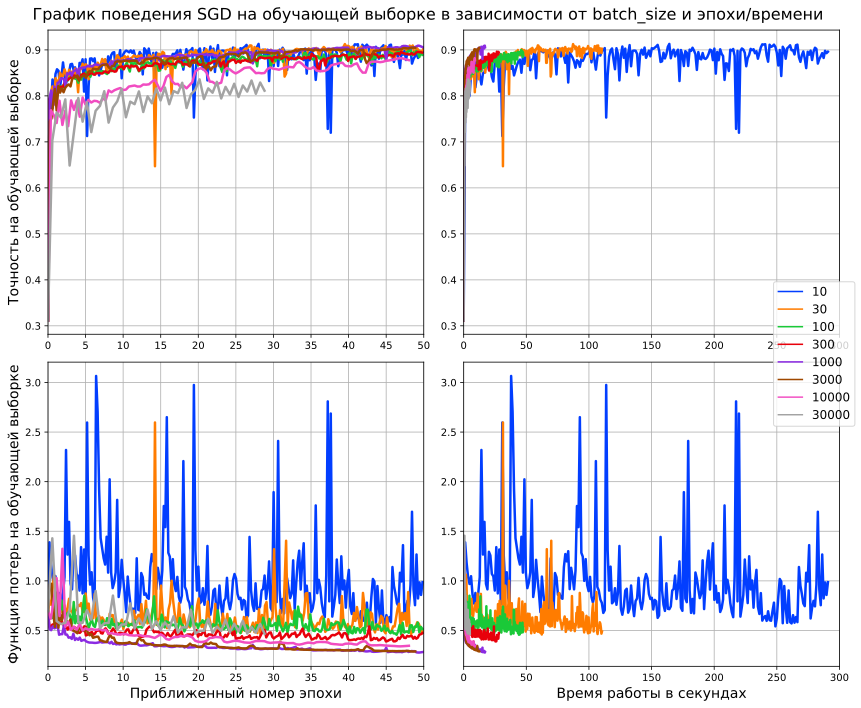

In [135]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

xlim_time = (0, 300)
xlim_iter = (0, 50)
xticks_iter = range(0, 51, 5)

fig.suptitle("График поведения SGD на обучающей выборке в зависимости от batch_size и эпохи/времени", fontsize=16)
sns.set_palette("tab20")

ax = axes[0, 0]
plot1 = sns.lineplot(data=acc_batch, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax = axes[0, 1]
plot2 = sns.lineplot(data=acc_time_batch, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_xlim(xlim_time)
ax.grid()

ax = axes[1, 0]
plot3 = sns.lineplot(data=loss_batch, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)

ax.set_xlabel("Приближенный номер эпохи", fontsize=14)
ax.set_ylabel("Функция потерь на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax= axes[1, 1]
plot4 = sns.lineplot(data=loss_time_batch, dashes=False, palette="bright", linewidth=2.5, legend=True, ax=ax)
ax.set_xlabel("Время работы в секундах", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(handles=handles, labels=labels, loc="center right", fontsize=12)

plt.savefig(fname='task2_exp5_batch.pdf')

plt.tight_layout()
plt.show()

## **5.4 Исследования поведения SGD от начального приближения**

In [136]:
w_history={}

default_sgd_args = {"loss_function": 'binary_logistic', "step_alpha": 1, "step_beta": 0,
                    "tolerance": 1e-5, "max_iter": 50, "random_seed": 153, "l2_coef": 0.00001, "batch_size": 1000}

for i in tqdm(range(1, 3), "normal"):
    w_norm = np.random.normal(scale=i, size=X_train_v.shape[1])
    
    model = SGDClassifier(**default_sgd_args)
    w_history[("norm" + str(i))] = model.fit(X_train_v, y_train, w_norm, trace=True, log_freq=0.2)

for i in tqdm(range(1, 4), "uniform"):
    w_uni = np.random.uniform(low=-i, high=i, size=X_train_v.shape[1])
    model = SGDClassifier(**default_sgd_args)
    w_history[("unif" + str(i))] = model.fit(X_train_v, y_train, w_uni, trace=True, log_freq=0.2)
    
w_null = np.zeros(X_train_v.shape[1])
model = SGDClassifier(**default_sgd_args)
w_history["null"] = model.fit(X_train_v, y_train, w_null, trace=True, log_freq=0.2)
print("null")

def w_min_t(X, y, min_num, **kwargs):
    np.random.seed(kwargs['random_seed'])
    kwargs["max_iter"] = 10
    model = SGDClassifier(**kwargs)
    indices = np.random.choice(X.shape[0], size=min_num, replace=False)
    model.fit(X[indices], y.iloc[indices], log_freq=0.2)
    return model.get_weights()
    
for num in tqdm([1000, 2000, 4000, 6000], "batch"):
    w_min = w_min_t(X_train_v, y_train, num, **default_sgd_args)

    model = SGDClassifier(**default_sgd_args)
    w_history["batch" + str(num)] = model.fit(X_train_v, y_train, w_min, trace=True, log_freq=0.2)


model = SGDClassifier(**default_sgd_args)
w_history["spec"] = model.fit(X_train_v, y_train, w_spec, trace=True, log_freq=0.2)
print("spec")

uniform: 100%|██████████| 3/3 [00:53<00:00, 17.84s/it]


null


batch: 100%|██████████| 4/4 [01:09<00:00, 17.26s/it]


spec


In [137]:
acc_w = {w_name: 
             {num_iter: acc for num_iter, acc in zip(w_history[w_name]['epoch_num'], w_history[w_name]['accuracy'])}
             for w_name in w_history.keys()}
acc_w = pd.DataFrame(acc_w)

loss_w = {w_name: 
             {num_iter: func for num_iter, func in zip(w_history[w_name]['epoch_num'], w_history[w_name]['func'])}
             for w_name in w_history.keys()}
loss_w = pd.DataFrame(loss_w)

acc_time_w = {w_name: 
             {time_work: acc for time_work, acc in zip(w_history[w_name]['time'], w_history[w_name]['accuracy'])}
             for w_name in w_history.keys()}
acc_time_w = pd.DataFrame(acc_time_w)

loss_time_w = {w_name: 
             {time_work: func for time_work, func in zip(w_history[w_name]['time'], w_history[w_name]['func'])}
             for w_name in w_history.keys()}
loss_time_w = pd.DataFrame(loss_time_w)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

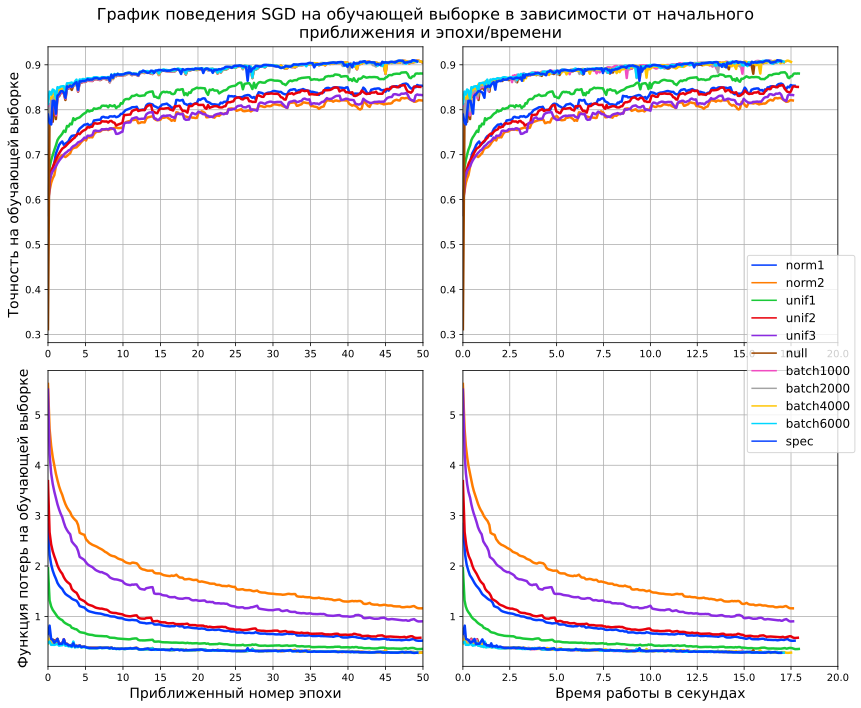

In [140]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

xlim_time = (0, 20)
xlim_iter = (0, 50)
xticks_iter = range(0, 51, 5)

fig.suptitle("График поведения SGD на обучающей выборке в зависимости от начального \n приближения и эпохи/времени", fontsize=16)
sns.set_palette("tab20")

ax = axes[0, 0]
plot1 = sns.lineplot(data=acc_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax = axes[0, 1]
plot2 = sns.lineplot(data=acc_time_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_xlim(xlim_time)
ax.grid()

ax = axes[1, 0]
plot3 = sns.lineplot(data=loss_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)

ax.set_xlabel("Приближенный номер эпохи", fontsize=14)
ax.set_ylabel("Функция потерь на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax= axes[1, 1]
plot4 = sns.lineplot(data=loss_time_w, dashes=False, palette="bright", linewidth=2.5, legend=True, ax=ax)
ax.set_xlabel("Время работы в секундах", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(handles=handles, labels=labels, loc="center right", fontsize=12)

plt.savefig(fname='task2_exp5_w.pdf')

plt.tight_layout()
plt.show()

# **6. Сравнение поведения GD и SGD**

## **Поиск параметров оптимальных для GD**

In [150]:
alpha_params = [0.01, 0.1, 1.0]
beta_params = [0.1, 0.001]

ab_history = {}
args = {"loss_function": 'binary_logistic', "step_alpha": 1, "step_beta": 0, "tolerance": 1e-5, "max_iter": 50, "l2_coef": 0.00001}
args['max_iter'] = 1000

for step_alpha in tqdm(alpha_params):
    args['step_alpha'] = step_alpha

    for step_beta in tqdm(beta_params):
        args['step_beta'] = step_beta
        model = GDClassifier(**args)
        index = f"alpha={step_alpha} beta={step_beta} "
        ab_history[index] = model.fit(X_train_v, y_train,
                                      w_spec, trace=True)

100%|██████████| 3/3 [05:26<00:00, 108.88s/it]


In [152]:
acc_w = {ab_name: 
             {num_iter: acc for num_iter, acc in enumerate(ab_history[ab_name]['accuracy'])}
             for ab_name in ab_history.keys()}
acc_w = pd.DataFrame(acc_w)

loss_w = {ab_name: 
             {num_iter: func for num_iter, func in enumerate(ab_history[ab_name]['func'])}
             for ab_name in ab_history.keys()}
loss_w = pd.DataFrame(loss_w)

acc_time_w = {ab_name: 
             {time_work: acc for time_work, acc in zip(ab_history[ab_name]['time'], ab_history[ab_name]['accuracy'])}
             for ab_name in ab_history.keys()}
acc_time_w = pd.DataFrame(acc_time_w)

loss_time_w = {ab_name: 
             {time_work: func for time_work, func in zip(ab_history[ab_name]['time'], ab_history[ab_name]['func'])}
             for ab_name in ab_history.keys()}
loss_time_w = pd.DataFrame(loss_time_w)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

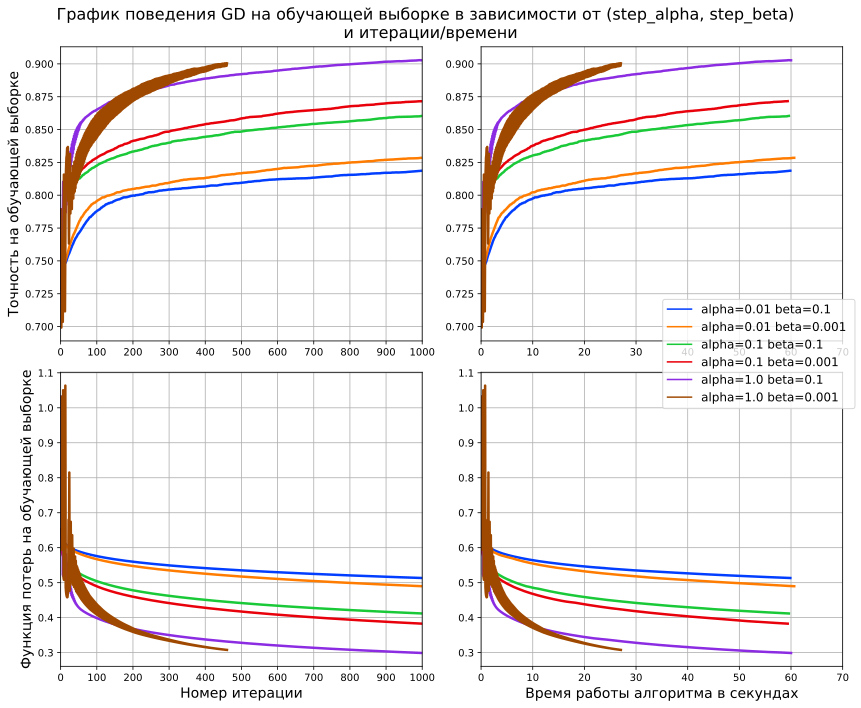

In [155]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

xlim_time = (0, 70)
xlim_iter = (0, 1000)
xticks_iter = range(0, 1001, 100)

fig.suptitle("График поведения GD на обучающей выборке в зависимости от (step_alpha, step_beta) \n и итерации/времени", fontsize=16)
sns.set_palette("tab20")

ax = axes[0, 0]
plot1 = sns.lineplot(data=acc_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax = axes[0, 1]
plot2 = sns.lineplot(data=acc_time_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_xlim(xlim_time)
ax.grid()

ax = axes[1, 0]
plot3 = sns.lineplot(data=loss_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)

ax.set_xlabel("Номер итерации", fontsize=14)
ax.set_ylabel("Функция потерь на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax= axes[1, 1]
plot4 = sns.lineplot(data=loss_time_w, dashes=False, palette="bright", linewidth=2.5, legend=True, ax=ax)
ax.set_xlabel("Время работы алгоритма в секундах", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(handles=handles, labels=labels, loc="center right", fontsize=12)

plt.savefig(fname='task2_exp6_gd.pdf')

plt.tight_layout()
plt.show()

## **Поиск параметров оптимальных для SGD**

In [146]:
alpha_params = [0.01, 0.1, 1.0]
beta_params = [0.001, 0.01]

ab_history = {}
args = {"loss_function": 'binary_logistic', "step_alpha": 1, "step_beta": 0,
                    "tolerance": 1e-5, "max_iter": 50, "random_seed": 153, "l2_coef": 0.00001, "batch_size": 1000}
args['max_iter'] = 1000

for step_alpha in tqdm(alpha_params):
    args['step_alpha'] = step_alpha

    for step_beta in tqdm(beta_params):
        args['step_beta'] = step_beta

        model = SGDClassifier(**args)
        index = f"beta={step_beta} alpha={step_alpha}"
        
        ab_history[index] = model.fit(X_train_v, y_train,
                                      w_spec, trace=True, log_freq=0.5)

100%|██████████| 3/3 [24:18<00:00, 486.08s/it]


In [147]:
acc_w = {ab_name: 
             {num_iter: acc for num_iter, acc in zip(ab_history[ab_name]['epoch_num'], ab_history[ab_name]['accuracy'])}
             for ab_name in ab_history.keys()}
acc_w = pd.DataFrame(acc_w)

loss_w = {ab_name: 
             {num_iter: func for num_iter, func in zip(ab_history[ab_name]['epoch_num'], ab_history[ab_name]['func'])}
             for ab_name in ab_history.keys()}
loss_w = pd.DataFrame(loss_w)

acc_time_w = {ab_name: 
             {time_work: acc for time_work, acc in zip(ab_history[ab_name]['time'], ab_history[ab_name]['accuracy'])}
             for ab_name in ab_history.keys()}
acc_time_w = pd.DataFrame(acc_time_w)

loss_time_w = {ab_name: 
             {time_work: func for time_work, func in zip(ab_history[ab_name]['time'], ab_history[ab_name]['func'])}
             for ab_name in ab_history.keys()}
loss_time_w = pd.DataFrame(loss_time_w)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

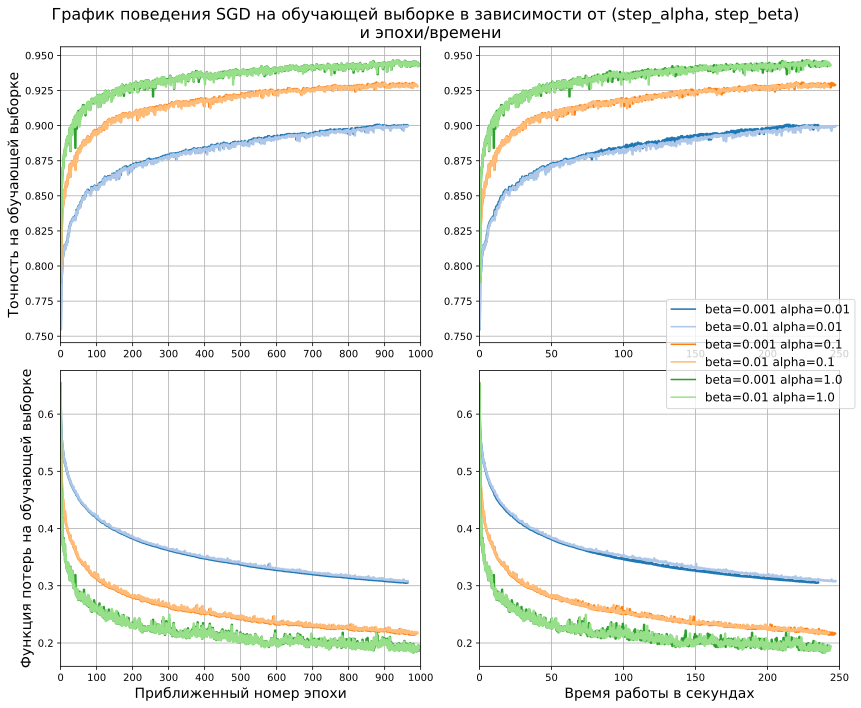

In [149]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

xlim_time = (0, 250)
xlim_iter = (0, 1000)
xticks_iter = range(0, 1001, 100)

sns.set_palette("tab20")

fig.suptitle("График поведения SGD на обучающей выборке в зависимости от (step_alpha, step_beta) \n и эпохи/времени", fontsize=16)

ax = axes[0, 0]
plot1 = sns.lineplot(data=acc_w, dashes=False, linewidth=2.5, legend=False, ax=ax)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax = axes[0, 1]
plot2 = sns.lineplot(data=acc_time_w, dashes=False, linewidth=2.5, legend=False, ax=ax)
ax.set_xlim(xlim_time)
ax.grid()

ax = axes[1, 0]
plot3 = sns.lineplot(data=loss_w, dashes=False, linewidth=2.5, legend=False, ax=ax)

ax.set_xlabel("Приближенный номер эпохи", fontsize=14)
ax.set_ylabel("Функция потерь на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax= axes[1, 1]
plot4 = sns.lineplot(data=loss_time_w, dashes=False, linewidth=2.5, legend=True, ax=ax)
ax.set_xlabel("Время работы в секундах", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(handles=handles, labels=labels, loc="center right", fontsize=12)

plt.savefig(fname='task2_exp6_sgd.pdf')

plt.tight_layout()
plt.show()

## **Сравнение 'оптимальных' GD и SGD**

In [156]:
np.random.seed(153)
indices = np.random.permutation(X_train_v.shape[0])

X_r = X_train_v[indices]
y_r = y_train.iloc[indices]

ratio = 0.8
split_index = int(X_train_v.shape[0] * ratio)

print("Размер обучающей выборки:", X_r[:split_index].shape)
print("Размер тестовой выборки:", X_r[split_index:].shape)

Размер обучающей выборки: (41648, 11237)
Размер тестовой выборки: (10413, 11237)


In [159]:
gd_args = {"loss_function": 'binary_logistic', "step_alpha": 1, "step_beta": 0.1,
            "tolerance": 1e-5, "max_iter": 1000,"l2_coef": 0.00001}
sgd_args = {"loss_function": 'binary_logistic', "step_alpha": 1.0, "step_beta": 0.001,
            "tolerance": 1e-5, "max_iter": 1000, "random_seed": 153, "l2_coef": 0.00001, "batch_size": 1000}

history = {}

gd = GDClassifier(**gd_args)
history["gd"] = gd.fit(X_r[:split_index], y_r[:split_index], w_spec, trace=True)

sgd = SGDClassifier(**sgd_args)
history["sgd"] = sgd.fit(X_r[:split_index], y_r[:split_index], w_spec, trace=True, log_freq=0.3)


acc = {"gd": gd.get_accuracy(X_r[split_index:], y_r[split_index:]),
       "sgd": sgd.get_accuracy(X_r[split_index:], y_r[split_index:])}

In [167]:
acc_vs = {ab_name: 
             {time_work: acc for time_work, acc in zip(history[ab_name]['time'], history[ab_name]['accuracy'])}
             for ab_name in history.keys()}
acc_vs = pd.DataFrame(acc_vs)

loss_vs = {ab_name: 
             {time_work: func for time_work, func in zip(history[ab_name]['time'], history[ab_name]['func'])}
             for ab_name in history.keys()}
loss_vs = pd.DataFrame(loss_vs)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

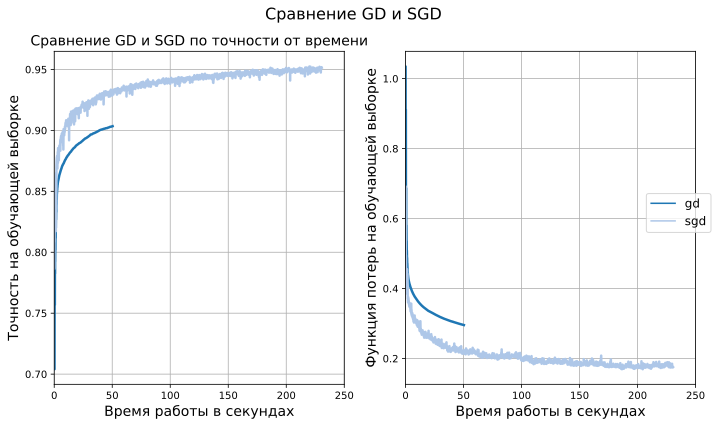

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

xlim_time = (0, 250)
xlim_iter = (0, 1000)
xticks_iter = range(0, 1001, 100)

sns.set_palette("tab20")

fig.suptitle("Сравнение GD и SGD ", fontsize=16)

ax = axes[0]
sns.lineplot(data=acc_vs, dashes=False, linewidth=2.5, legend=False, ax=ax)
ax.set_title("Сравнение GD и SGD по точности от времени", fontsize=14)
ax.set_xlabel("Время работы в секундах", fontsize=14)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()


ax = axes[1]
sns.lineplot(data=loss_vs, dashes=False, linewidth=2.5, legend=True, ax=ax)
ax.set_xlabel("Время работы в секундах", fontsize=14)
ax.set_ylabel("Функция потерь на обучающей выборке", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(handles=handles, labels=labels, loc="center right", fontsize=12)

plt.savefig(fname='task2_exp6_vs.pdf')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


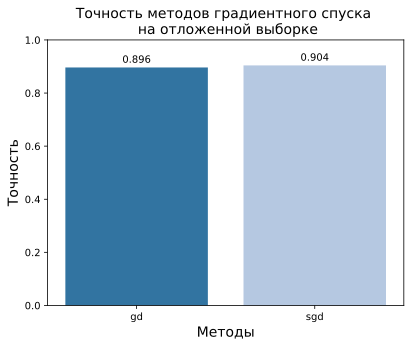

In [183]:
methods = list(acc.keys())
accuracies = list(acc.values())

sns.barplot(x=methods, y=accuracies)

for i, acc_value in enumerate(accuracies):
    plt.text(i, acc_value + 0.01, f'{acc_value:.3f}', ha='center', va='bottom', fontsize=10)
    
plt.title('Точность методов градиентного спуска \n на отложенной выборке', fontsize=14)
plt.xlabel('Методы', fontsize=14)
plt.ylabel('Точность', fontsize=14)
plt.ylim(0, 1)
plt.savefig(fname='task2_exp6_vs_acc.pdf')
plt.show()

# **7. Исследование влияния лемматизации текста на точность, время работы и размерность пространства**

In [13]:
np.random.seed(153)
indices = np.random.permutation(X_train.shape[0])

ratio = 0.8
split_index = int(X_train.shape[0] * ratio)

y_train_v = y_train.iloc[indices][:split_index]
y_test_v = y_train.iloc[indices][split_index:]

In [14]:
import nltk
from nltk.corpus import wordnet, stopwords

nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [16]:
lemmatizer = nltk.WordNetLemmatizer()
lemmatizer.lemmatize("hello")

'hello'

In [17]:
stop_words = set(stopwords.words("english"))

def lemmatize_text(text: str):
    return " ".join([lemmatizer.lemmatize(word)
                     for word in text.split() if word not in stop_words])


X_train['comment_text'] = X_train['comment_text'].map(lambda x: lemmatize_text(x))
X_test['comment_text'] = X_test['comment_text'].map(lambda x: lemmatize_text(x))

In [18]:
X_train.head(5)

comment_text  is_toxic
0  explanation edits made username hardcore metal...     False
1  aww match background colour seemingly stuck th...     False
2  hey man really trying edit war guy constantly ...     False
3  make real suggestion improvement wondered sect...     False
4                      sir hero chance remember page     False

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=10)

X_train_v = vectorizer.fit_transform(X_train['comment_text'])
X_text_v = vectorizer.transform(X_test['comment_text'])

print(X_train_v.shape)

(52061, 10071)


In [25]:
from tqdm import tqdm

w_spec = np.zeros(X_r[:split_index].shape[1])

for i in tqdm(range(X_r[:split_index].shape[1])):
    num = X_r[:split_index][:, i].T @ y_r[:split_index]
    den = np.sum(X_r[:split_index][:, i].dot(X_r[:split_index][:, i].T))
    w_spec[i] = num / den

  0%|          | 0/10071 [00:00<?, ?it/s]/tmp/ipykernel_30/1589485530.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w_spec[i] = num / den
100%|██████████| 10071/10071 [09:24<00:00, 17.84it/s]


In [40]:
sgd_args = {"loss_function": 'binary_logistic', "step_alpha": 1.0, "step_beta": 0.001,
            "tolerance": 1e-5, "max_iter": 1000, "random_seed": 153, "l2_coef": 0.00001, "batch_size": 1000}

sgd = SGDClassifier(**sgd_args)
history = sgd.fit(X_r[:split_index], y_r[:split_index], w_spec, trace=True, log_freq=0.3)


acc = {"sgd": sgd.get_accuracy(X_r[split_index:], y_r[split_index:])}

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


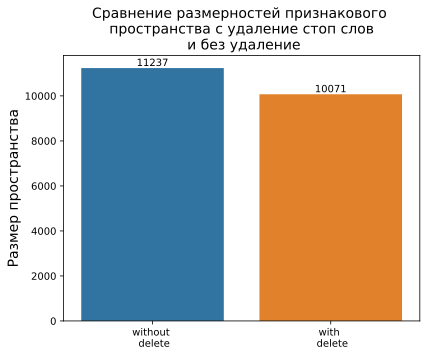

In [33]:
methods = ['without \n delete', 'with \n delete']
count_size = [11237, 10071]

sns.barplot(x=methods, y=count_size)

for i, count in enumerate(count_size):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)
    
plt.title('Сравнение размерностей признакового \n пространства с удаление стоп слов \n и без удаление', fontsize=14)
plt.ylabel('Размер пространства', fontsize=14)
plt.savefig(fname='task2_exp7_stop.pdf')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


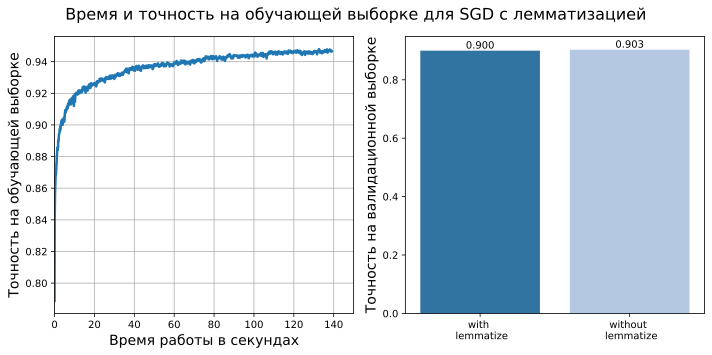

In [58]:
time_s = {'sgd': 
             {time_work: acc for time_work, acc in zip(history['time'], history['accuracy'])}}
time_s = pd.DataFrame(time_s)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

xlim_time = (0, 150)
xlim_iter = (0, 1000)
xticks_iter = range(0, 1001, 100)

sns.set_palette("tab20")

fig.suptitle("Время и точность на обучающей выборке для SGD с лемматизацией", fontsize=16)

ax = axes[0]
sns.lineplot(data=time_s, dashes=False, linewidth=2.5, legend=False, ax=ax)
ax.set_xlabel("Время работы в секундах", fontsize=14)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()


ax = axes[1]
sns.barplot(x=['with \n lemmatize', 'without \n lemmatize'], y=[acc['sgd'], 0.903], ax=ax)

for i, accu in enumerate([acc['sgd'], 0.903]):
    ax.text(i, accu, f'{accu:.3f}', ha='center', va='bottom', fontsize=10)
ax.set_ylabel('Точность на валидационной выборке', fontsize=14)

plt.savefig(fname='task2_exp7_time.pdf')

plt.tight_layout()
plt.show()

# **8. Исследование качества, время работы алгоритма и размер признакового пространства в зависимости от представления и параметров min_df и max_df**

## **8.1 Исследование качества, время работы алгоритма и размера признакового пространства в зависимости от представления**

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tqdm import tqdm

history = {"bow": {}, "tfidf": {}}

#Bag of words
bag = CountVectorizer(min_df=10)
X_train_v = bag.fit_transform(X_train['comment_text'].iloc[indices][:split_index])
X_test_v = bag.transform(X_train['comment_text'].iloc[indices][split_index:])
history["bow"]["size_space"] = X_train_v.shape[1]

#Подсчет начального приближения

w_spec = np.zeros(X_train_v.shape[1])

for i in tqdm(range(X_train_v.shape[1])):
    num = X_train_v[:, i].T @ y_train_v
    den = np.sum(X_train_v[:, i].dot(X_train_v[:, i].T))
    w_spec[i] = num / den

# обучение модели
sgd = SGDClassifier(**default_args)
history["bow"] = sgd.fit(X_train_v, y_train_v, w_spec, trace=True, log_freq=0.3)
history["bow"]["acc"] = sgd.get_accuracy(X_test_v, y_test_v)

#TF_IDF
transformer = TfidfTransformer()
X_train_v1 = transformer.fit_transform(X_train_v)
X_test_v1 = transformer.transform(X_test_v)
history["tfidf"]["size_space"] = X_train_v1.shape[1]

#Подсчет начального приближения

w_spec = np.zeros(X_train_v1.shape[1])

for i in tqdm(range(X_train_v1.shape[1])):
    num = X_train_v1[:, i].T @ y_train_v
    den = np.sum(X_train_v1[:, i].dot(X_train_v1[:, i].T))
    w_spec[i] = num / den

#обучение модели

sgd = SGDClassifier(**default_args)
history["tfidf"] = sgd.fit(X_train_v1, y_train_v, w_spec, trace=True, log_freq=0.3)
history["tfidf"]["acc"] = sgd.get_accuracy(X_test_v1, y_test_v)

  0%|          | 0/8879 [00:00<?, ?it/s]/tmp/ipykernel_30/3624313831.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w_spec[i] = num / den
  0%|          | 0/8879 [00:00<?, ?it/s]/tmp/ipykernel_30/3624313831.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w_spec[i] = num / den
100%|██████████| 8879/8879 [01:56<00:00, 75.97it/s]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


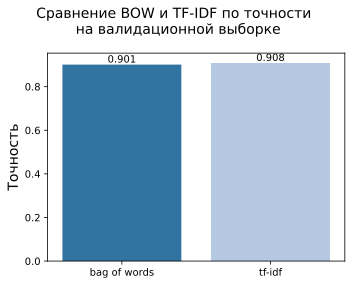

In [34]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))

xlim_time = (0, 150)
xlim_iter = (0, 1000)
xticks_iter = range(0, 1001, 100)

sns.set_palette("tab20")

fig.suptitle("Сравнение BOW и TF-IDF по точности \n на валидационной выборке", fontsize=14)

ax = axes
sns.barplot(x=['bag of words', 'tf-idf'], y=[history['bow']['acc'], history['tfidf']['acc']], ax=ax)


for i, accu in enumerate([history['bow']['acc'], history['tfidf']['acc']]):
    ax.text(i, accu, f'{accu:.3f}', ha='center', va='bottom', fontsize=10)
ax.set_ylabel('Точность', fontsize=14)

plt.savefig(fname='task2_exp8_acc.pdf')

plt.tight_layout()
plt.show()

In [35]:
acc_w = {ab_name: 
             {num_iter: acc for num_iter, acc in zip(history[ab_name]['epoch_num'], history[ab_name]['accuracy'])}
             for ab_name in history.keys()}
acc_w = pd.DataFrame(acc_w)

loss_w = {ab_name: 
             {num_iter: func for num_iter, func in zip(history[ab_name]['epoch_num'], history[ab_name]['func'])}
             for ab_name in history.keys()}
loss_w = pd.DataFrame(loss_w)

acc_time_w = {ab_name: 
             {time_work: acc for time_work, acc in zip(history[ab_name]['time'], history[ab_name]['accuracy'])}
             for ab_name in history.keys()}
acc_time_w = pd.DataFrame(acc_time_w)

loss_time_w = {ab_name: 
             {time_work: func for time_work, func in zip(history[ab_name]['time'], history[ab_name]['func'])}
             for ab_name in history.keys()}
loss_time_w = pd.DataFrame(loss_time_w)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

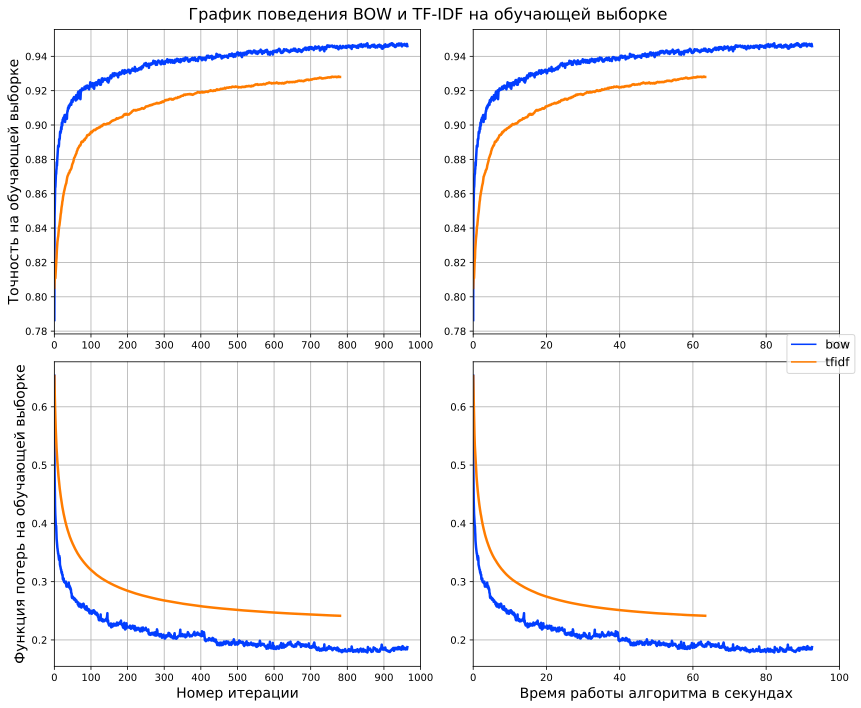

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

xlim_time = (0, 100)
xlim_iter = (0, 1000)
xticks_iter = range(0, 1001, 100)

fig.suptitle("График поведения BOW и TF-IDF на обучающей выборке", fontsize=16)
sns.set_palette("tab20")

ax = axes[0, 0]
plot1 = sns.lineplot(data=acc_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax = axes[0, 1]
plot2 = sns.lineplot(data=acc_time_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_xlim(xlim_time)
ax.grid()

ax = axes[1, 0]
plot3 = sns.lineplot(data=loss_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)

ax.set_xlabel("Номер итерации", fontsize=14)
ax.set_ylabel("Функция потерь на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax= axes[1, 1]
plot4 = sns.lineplot(data=loss_time_w, dashes=False, palette="bright", linewidth=2.5, legend=True, ax=ax)
ax.set_xlabel("Время работы алгоритма в секундах", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(handles=handles, labels=labels, loc="center right", fontsize=12)

plt.savefig(fname='task2_exp8_vs.pdf')

plt.tight_layout()
plt.show()

## **8.2 Исследование качества работы, время работы алгоритма и размера признакового пространства от параметров min_df и max_df**

In [136]:
params_max_df = [0.15, 0.2, 0.3]
params_min_df = [5, 10, 20, 30]

history = {}

default_args = {"loss_function": 'binary_logistic', "step_alpha": 1.0, "step_beta": 0.001,
            "tolerance": 1e-5, "max_iter": 1000, "random_seed": 153, "l2_coef": 0.00001, "batch_size": 1000}
spec_args = {"loss_function": 'binary_logistic', "step_alpha": 1.0, "step_beta": 0.001,
            "tolerance": 1e-5, "max_iter": 100, "random_seed": 153, "l2_coef": 0.00001, "batch_size": 1000}

for max_df in params_max_df:
    for min_df in params_min_df:
        index = f"min_df={min_df} max_df={max_df}"
        history[index] = {}

for max_df in tqdm(params_max_df, "max_df"):
    for min_df in tqdm(params_min_df, "min_df"):
        index = f"min_df={min_df} max_df={max_df}"

        #Bag of words
        bag = CountVectorizer(min_df=min_df, max_df=max_df)
        X_train_v = bag.fit_transform(X_train['comment_text'].iloc[indices][:split_index])
        X_test_v = bag.transform(X_train['comment_text'].iloc[indices][split_index:])
        history[index]["size_space"] = X_train_v.shape[1]
    
        #Подсчет начального приближения
        w_spec = w_min_t(X_train_v, y_train, 6000, **spec_args)

        # обучение модели
        sgd = SGDClassifier(**default_args)
        history[index]["result"] = sgd.fit(X_train_v, y_train_v, w_spec, trace=True, log_freq=0.3)
        history[index]["acc"] = sgd.get_accuracy(X_test_v, y_test_v)

max_df: 100%|██████████| 3/3 [23:20<00:00, 466.93s/it]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


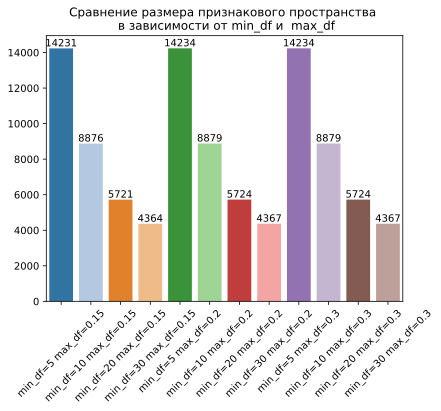

In [137]:
indexes = list(history.keys())
space_size_array = [history[index]["size_space"] for index in indexes]


sns.barplot(x=indexes, y=space_size_array)
plt.title("Сравнение размера признакового пространства \n в зависимости от min_df и  max_df")
plt.xticks(rotation=45)

for i, size_array in enumerate(space_size_array):
    plt.text(i, size_array, f'{size_array}', ha='center', va='bottom', fontsize=10)

plt.savefig(fname='task2_exp8_df_size.pdf')
plt.show()

In [138]:
acc_w = {ab_name: 
             {num_iter: acc for num_iter, acc in zip(history[ab_name]["result"]['epoch_num'], history[ab_name]["result"]['accuracy'])}
             for ab_name in history.keys()}
acc_w = pd.DataFrame(acc_w)

loss_w = {ab_name: 
             {num_iter: func for num_iter, func in zip(history[ab_name]["result"]['epoch_num'], history[ab_name]["result"]['func'])}
             for ab_name in history.keys()}
loss_w = pd.DataFrame(loss_w)

acc_time_w = {ab_name: 
             {time_work: acc for time_work, acc in zip(history[ab_name]["result"]['time'], history[ab_name]["result"]['accuracy'])}
             for ab_name in history.keys()}
acc_time_w = pd.DataFrame(acc_time_w)

loss_time_w = {ab_name: 
             {time_work: func for time_work, func in zip(history[ab_name]["result"]['time'], history[ab_name]["result"]['func'])}
             for ab_name in history.keys()}
loss_time_w = pd.DataFrame(loss_time_w)

In [139]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

xlim_time = (0, 100)
xlim_iter = (0, 1000)
xticks_iter = range(0, 1001, 100)

fig.suptitle("График поведения SGD при изменении min_df и max_df", fontsize=16)
sns.set_palette("tab20")

ax = axes[0, 0]
plot1 = sns.lineplot(data=acc_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax = axes[0, 1]
plot2 = sns.lineplot(data=acc_time_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_xlim(xlim_time)
ax.grid()

ax = axes[1, 0]
plot3 = sns.lineplot(data=loss_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)

ax.set_xlabel("Номер эпохи", fontsize=14)
ax.set_ylabel("Функция потерь на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax= axes[1, 1]
plot4 = sns.lineplot(data=loss_time_w, dashes=False, palette="bright", linewidth=2.5, legend=True, ax=ax)
ax.set_xlabel("Время работы алгоритма в секундах", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(handles=handles, labels=labels, loc="center right", fontsize=12)

plt.savefig(fname='task2_exp8_df.pdf')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


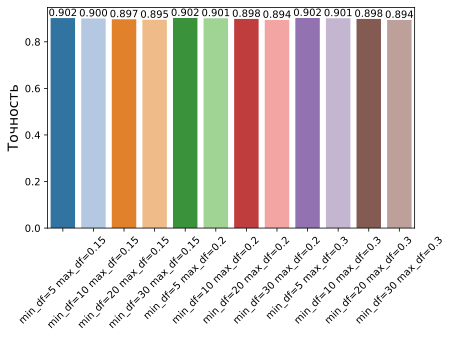

In [140]:
accura_values = [history[index]["acc"] for index in history.keys()]
indexes = list(history.keys())

sns.set_palette("tab20")

sns.barplot(x=indexes, y=accura_values)


for i, accu in enumerate(accura_values):
    plt.text(i, accu, f'{accu:.3f}', ha='center', va='bottom', fontsize=10)
plt.ylabel('Точность', fontsize=14)
plt.xticks(rotation=45)
plt.savefig(fname='task2_exp8_acc2.pdf')

plt.tight_layout()
plt.show()

# **9. Выбор лучшего алгоритма и анализ объектов, на которых он допускает ошибку**

In [20]:
default_sgd_args = {"loss_function": 'binary_logistic', "step_alpha": 1.0, "step_beta": 0.001,
            "tolerance": 1e-5, "max_iter": 10000, "random_seed": 153, "l2_coef": 0.00001, "batch_size": 1000}

y_train = X_train['is_toxic'].map({True: 1, False: -1})
y_test = X_test['is_toxic'].map({True: 1, False: -1})

history = {"bow": {}, "tfidf": {}}

#Bag of words
bag = CountVectorizer(min_df=5, max_df=0.2)
X_train_v = bag.fit_transform(X_train['comment_text'])
X_test_v = bag.transform(X_test['comment_text'])


#Подсчет начального приближения

w_spec = np.zeros(X_train_v.shape[1])

for i in tqdm(range(X_train_v.shape[1])):
    num = X_train_v[:, i].T @ y_train
    den = np.sum(X_train_v[:, i].dot(X_train_v[:, i].T))
    w_spec[i] = num / den

# обучение модели
sgd = SGDClassifier(**default_sgd_args)
history["bow"]["result"] = sgd.fit(X_train_v, y_train, w_spec, trace=True, log_freq=0.3)
history["bow"]["acc"] = sgd.get_accuracy(X_test_v, y_test)

#TF_IDF
transformer = TfidfTransformer()
X_train_v1 = transformer.fit_transform(X_train_v)
X_test_v1 = transformer.transform(X_test_v)
history["tfidf"]["size_space"] = X_train_v1.shape[1]

#Подсчет начального приближения

w_spec = np.zeros(X_train_v1.shape[1])

for i in tqdm(range(X_train_v1.shape[1])):
    num = X_train_v1[:, i].T @ y_train
    den = np.sum(X_train_v1[:, i].dot(X_train_v1[:, i].T))
    w_spec[i] = num / den

#обучение модели

sgd = SGDClassifier(**default_sgd_args)
history["tfidf"]["result"] = sgd.fit(X_train_v1, y_train, w_spec, trace=True, log_freq=0.3)
history["tfidf"]["acc"] = sgd.get_accuracy(X_test_v1, y_test)

  0%|          | 0/16247 [00:00<?, ?it/s]/tmp/ipykernel_30/1621172770.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w_spec[i] = num / den
100%|██████████| 16247/16247 [05:59<00:00, 45.18it/s]


NameError: name 'TfidfTransformer' is not defined

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


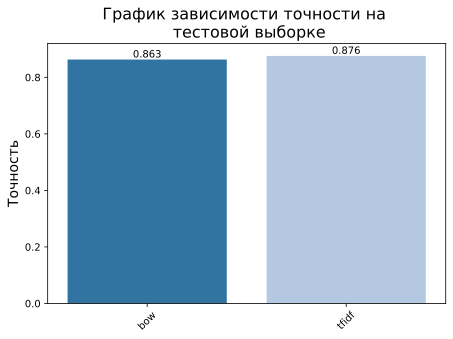

In [80]:
accuraccy_values = [history[index]["acc"] for index in history.keys()]
indexes = list(history.keys())

sns.set_palette("tab20")

sns.barplot(x=indexes, y=accura_values)

plt.title("График зависимости точности на \n тестовой выборке", fontsize=16)
for i, accu in enumerate(accura_values):
    plt.text(i, accu, f'{accu:.3f}', ha='center', va='bottom', fontsize=10)
plt.ylabel('Точность', fontsize=14)
plt.xticks(rotation=45)

plt.savefig(fname='task2_exp9_ac.pdf')

plt.tight_layout()
plt.show()

In [84]:
print(sgd.get_weights().shape)

(16247,)
(20676, 2)


In [86]:
Z = sgd.predict(X_test_v1)
X_error = X_test[y_test != Z]

In [89]:
X_error_1 = X_error[X_error["is_toxic"]]
X_error_2 = X_error[X_error["is_toxic"] == False]

In [141]:
print(X_error_1.shape[0] / X_test.shape[0])
print(X_error_2.shape[0] / X_test.shape[0])

0.028922422131940413
0.09518282066163668


In [142]:
list(X_error_1["comment_text"])[:20]

['utterly utterly tiny insignificant anal retentive thing later learned dan marino kidnap join snowflake missed ped end kidnap',
 'removed frog penis caption real name raumskulptur translates spacial sculpture take snap sign next time campus pink bicycle mounted pole 100m nort sculpture',
 'someone please edit line lebanon operation u army center military history contingency operation fckin stupid hoee end article tl',
 'shut silly change episode number whenever bussiness god going give right ok stupid season 2 24 episode 87 regular episode 86 understand wrong one try change episode number like ok want play ok play together swear wikipedia tell administrator selfish possible write desperate housewife page member agree 24 episode season 2 something sure end day wikipedia stop adam stop adam stop adam',
 'ok true hello mean stuiped stpido knw boob hebrew zizim',
 'stupidest thing disney ever done hannah montana pointless show stupider regular show cartoon network',
 'hi giggy puny shonen

In [1]:
list(X_error_2["comment_text"])[100:120]

NameError: name 'X_error_2' is not defined

# **10. Исследование влияния качества и времени работы алгоритма от размера максимальных n-gramm**

In [108]:
def w_min_t(X, y, min_num, **kwargs):
    np.random.seed(kwargs['random_seed'])
    kwargs["max_iter"] = 10
    model = SGDClassifier(**kwargs)
    indices = np.random.choice(X.shape[0], size=min_num, replace=False)
    model.fit(X[indices], y.iloc[indices], log_freq=0.2)
    return model.get_weights()

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

default_sgd_args = {"loss_function": 'binary_logistic', "step_alpha": 1.0, "step_beta": 0.001,
            "tolerance": 1e-5, "max_iter": 10000, "random_seed": 153, "l2_coef": 0.00001, "batch_size": 1000}
spec_args = {"loss_function": 'binary_logistic', "step_alpha": 1.0, "step_beta": 0.001,
            "tolerance": 1e-5, "max_iter": 100, "random_seed": 153, "l2_coef": 0.00001, "batch_size": 1000}
history = {str(n_max): {} for n_max in range(1, 5)}

for n_max in range(1, 4):

    index = str(n_max)
    model = TfidfVectorizer(min_df=5, max_df=0.2, ngram_range=(1, n_max))
    X_train_v = model.fit_transform(X_train["comment_text"])
    X_test_v = model.transform(X_test["comment_text"])
    
    history[index]["size_space"] = X_train_v.shape[1]
    
    #Подсчет начального приближения
    w_spec = w_min_t(X_train_v, y_train, 6000, **spec_args)

    sgd = SGDClassifier(**default_args)
    history[index]["result"] = sgd.fit(X_train_v, y_train, w_spec, trace=True, log_freq=0.4)
    history[index]["acc"] = sgd.get_accuracy(X_test_v, y_test)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


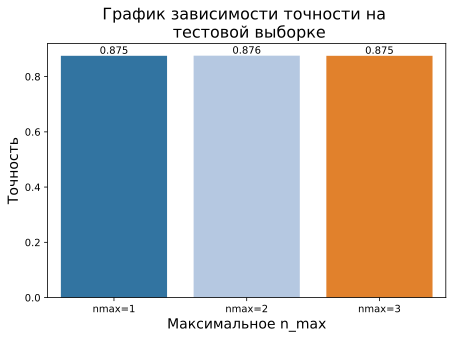

In [127]:
accuraccy_values = [history[index]["acc"] for index in ["1", "2", "3"]]
indexes = ["nmax=1", "nmax=2", "nmax=3"]

sns.set_palette("tab20")

sns.barplot(x=indexes, y=accuraccy_values)

plt.title("График зависимости точности на \n тестовой выборке", fontsize=16)
for i, accu in enumerate(accuraccy_values):
    plt.text(i, accu, f'{accu:.3f}', ha='center', va='bottom', fontsize=10)
plt.ylabel('Точность', fontsize=14)
plt.xlabel("Максимальное n_max", fontsize=14)

plt.savefig(fname='task2_exp10_ac.pdf')

plt.tight_layout()
plt.show()

In [129]:
acc_w = {ab_name: 
             {num_iter: acc for num_iter, acc in zip(history[ab_name]["result"]['epoch_num'], history[ab_name]["result"]['accuracy'])}
             for ab_name in history.keys()}
acc_w = pd.DataFrame(acc_w)

loss_w = {ab_name: 
             {num_iter: func for num_iter, func in zip(history[ab_name]["result"]['epoch_num'], history[ab_name]["result"]['func'])}
             for ab_name in history.keys()}
loss_w = pd.DataFrame(loss_w)

acc_time_w = {ab_name: 
             {time_work: acc for time_work, acc in zip(history[ab_name]["result"]['time'], history[ab_name]["result"]['accuracy'])}
             for ab_name in history.keys()}
acc_time_w = pd.DataFrame(acc_time_w)

loss_time_w = {ab_name: 
             {time_work: func for time_work, func in zip(history[ab_name]["result"]['time'], history[ab_name]["result"]['func'])}
             for ab_name in history.keys()}
loss_time_w = pd.DataFrame(loss_time_w)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

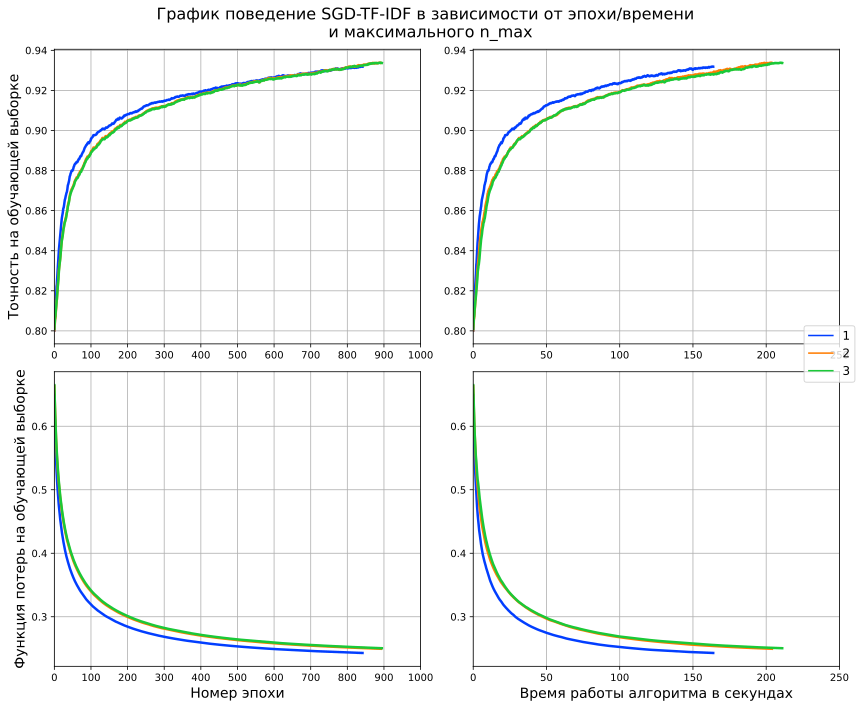

In [135]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

xlim_time = (0, 250)
xlim_iter = (0, 1000)
xticks_iter = range(0, 1001, 100)

fig.suptitle("График поведение SGD-TF-IDF в зависимости от эпохи/времени \n и максимального n_max", fontsize=16)
sns.set_palette("tab20")

ax = axes[0, 0]
plot1 = sns.lineplot(data=acc_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_ylabel("Точность на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax = axes[0, 1]
plot2 = sns.lineplot(data=acc_time_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)
ax.set_xlim(xlim_time)
ax.grid()

ax = axes[1, 0]
plot3 = sns.lineplot(data=loss_w, dashes=False, palette="bright", linewidth=2.5, legend=False, ax=ax)

ax.set_xlabel("Номер эпохи", fontsize=14)
ax.set_ylabel("Функция потерь на обучающей выборке", fontsize=14)
ax.set_xticks(xticks_iter)
ax.set_xlim(xlim_iter)
ax.grid()

ax= axes[1, 1]
plot4 = sns.lineplot(data=loss_time_w, dashes=False, palette="bright", linewidth=2.5, legend=True, ax=ax)
ax.set_xlabel("Время работы алгоритма в секундах", fontsize=14)
ax.set_xlim(xlim_time)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(handles=handles, labels=labels, loc="center right", fontsize=12)

plt.savefig(fname='task2_exp10_time1.pdf')

plt.tight_layout()
plt.show()

# **11. Исследование качества работы алгоритма от реализации SGD с отсутствием полной выборки в оперативной памяти**

# **12. Улучшение качества работы алгоритма с помощью других средств**